<a href="https://colab.research.google.com/github/Hamid-Mofidi/PINNs_on_Multiple_timescale_dynamics/blob/main/Examples/pinns_vanDerPol_cubic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cubic vanDerPol (IVP)
 See page 253 of the Book "Multiple_time_scale_dynamics" by Kuehn

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# define ODEs
def VanDerPol_cubic(y, t, mu):
    x, y = y
    #dxdt = y
    #dydt = epsilon * (1 - x**2) * y - x
    # mu = 1/epsilon
    dxdt = mu * (y - (1/3) * x**3 + x)
    dydt = - x
    return [dxdt, dydt]

y0 = [3/2, -3/8]   # See page 253 of the Book Multiple_time_scale_dynamics by Kuehn
# tau = epsilon * t    # for epsilon 0.01 and t =50, tau becomes 0.5
tau = np.linspace(0, 0.5, 100)
#epsilon = 0.01
mu = 100 # mu = 1/epsilon , epsilon = 0.01
#epsilon = 2

# solve ODEs
x_real, y_real = odeint(VanDerPol_cubic, y0, tau, args=(mu,)).T
# tranform to tensor
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float32)
x_real_tensor = torch.tensor(x_real.reshape(-1, 1), dtype=torch.float32)
y_real_tensor = torch.tensor(y_real.reshape(-1, 1), dtype=torch.float32)

def input_transform(tau_tensor):
    return torch.cat([tau_tensor], dim=1)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.fc1 = nn.Linear(1, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, tau):
        tau = input_transform(tau)
        x = torch.tanh(self.fc1(tau))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def loss_func(model, tau_tensor, x_real, y_real, x0, y0, mu, random_points=10):

    tau_tensor.requires_grad = True
    pred = model(tau_tensor)
    x_pred, y_pred = pred[:, 0].unsqueeze(1), pred[:, 1].unsqueeze(1)

    dx_dt = torch.autograd.grad(x_pred.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]

    #residual1 = dx_dt - y_pred
    #residual2 = dy_dt - (epsilon *(1 - x_pred**2) * y_pred - x_pred)
    residual1 = dx_dt - mu * (y_pred - (1/3) * x_pred**3 + x_pred)
    residual2 = dy_dt + x_pred

    init_loss = torch.square(x_pred[0] - x0) + torch.square(y_pred[0] - y0)
    physics_loss = torch.mean(residual1**2 + residual2**2)
    #data_loss = torch.mean((pred_x - x_real)**2 + (pred_y - y_real)**2)
    random_indices = torch.randint(0, x_real.shape[0], (random_points,))
    data_loss = torch.mean((x_pred[random_indices] - x_real[random_indices])**2 +
                           (y_pred[random_indices] - y_real[random_indices])**2)

    #adjust weights
    total_loss = physics_loss + 0.01*init_loss + 10*data_loss
    #total_loss = data_loss
    return total_loss

if __name__=='__main__':

    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_values = []
    epoch_num = 200000
    for epoch in range(epoch_num):

        loss = loss_func(model, tau_tensor, x_real_tensor, y_real_tensor, y0[0], y0[1], mu, random_points=10)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
        loss_values.append(loss.item())

    plt.figure(figsize=(8, 4))
    plt.plot(range(0, epoch_num, 1000), loss_values[:epoch_num//1000], 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()



    # model evaluation
    model.eval()
    with torch.no_grad():
        x_pred, y_pred = model(tau_tensor).numpy().T

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(tau * mu, x_real, 'b-', label='x')
    plt.plot(tau * mu, x_pred, 'r--', label='PINN')
    plt.xlabel('Time(t)')
    plt.ylabel('x')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(tau * mu, y_real, 'b-', label='y')
    plt.plot(tau * mu, y_pred, 'r--', label='PINN')
    plt.xlabel('Time(t)')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [ ]:
# define ODEs
def VanDerPol_cubic(y, t, mu):
    x, y = y
    #dxdt = y
    #dydt = epsilon * (1 - x**2) * y - x
    # mu = 1/epsilon
    dxdt = mu * (y - (1/3) * x**3 + x)
    dydt = - x
    return [dxdt, dydt]

In [ ]:
'''
y0 = [0.002, 0.0]
t = np.linspace(0, 120, 100)
epsilon = -0.1
'''
#y0 = [2, 0]
y0 = [3/2, -3/8]   # See page 253 of the Book Multiple_time_scale_dynamics by Kuehn
# tau = epsilon * t    # for epsilon 0.01 and t =50, tau becomes 0.5
tau = np.linspace(0, 0.5, 100)
#epsilon = 0.01
mu = 100 # mu = 1/epsilon , epsilon = 0.01
#epsilon = 2

In [ ]:
# solve ODEs
x_real, y_real = odeint(VanDerPol_cubic, y0, tau, args=(mu,)).T
# tranform to tensor
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float32)
x_real_tensor = torch.tensor(x_real.reshape(-1, 1), dtype=torch.float32)
y_real_tensor = torch.tensor(y_real.reshape(-1, 1), dtype=torch.float32)

In [ ]:
'''
def input_transform(t_tensor):
    sin_cos_features = [torch.sin(n * t_tensor) for n in range(1, 3)] + \
                       [torch.cos(n * t_tensor) for n in range(1, 3)] + \
                       [-torch.sin(n * t_tensor) for n in range(1, 3)]
    return torch.cat([t_tensor] + sin_cos_features, dim=1)
'''
def input_transform(tau_tensor):
    return torch.cat([tau_tensor], dim=1)

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.fc1 = nn.Linear(1, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, tau):
        tau = input_transform(tau)
        x = torch.tanh(self.fc1(tau))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def loss_func(model, tau_tensor, x_real, y_real, x0, y0, mu, random_points=10):

    tau_tensor.requires_grad = True
    pred = model(tau_tensor)
    x_pred, y_pred = pred[:, 0].unsqueeze(1), pred[:, 1].unsqueeze(1)

    dx_dt = torch.autograd.grad(x_pred.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]

    #residual1 = dx_dt - y_pred
    #residual2 = dy_dt - (epsilon *(1 - x_pred**2) * y_pred - x_pred)
    residual1 = dx_dt - mu * (y_pred - (1/3) * x_pred**3 + x_pred)
    residual2 = dy_dt + x_pred

    init_loss = torch.square(x_pred[0] - x0) + torch.square(y_pred[0] - y0)
    physics_loss = torch.mean(residual1**2 + residual2**2)
    #data_loss = torch.mean((pred_x - x_real)**2 + (pred_y - y_real)**2)
    random_indices = torch.randint(0, x_real.shape[0], (random_points,))
    data_loss = torch.mean((x_pred[random_indices] - x_real[random_indices])**2 +
                           (y_pred[random_indices] - y_real[random_indices])**2)

    #adjust weights
    total_loss = physics_loss + 0.01*init_loss + 10*data_loss
    #total_loss = data_loss
    return total_loss

Epoch 0, Loss: 120.46968078613281
Epoch 1000, Loss: 25.460914611816406
Epoch 2000, Loss: 24.50318717956543
Epoch 3000, Loss: 24.10014533996582
Epoch 4000, Loss: 12.069339752197266
Epoch 5000, Loss: 23.863018035888672
Epoch 6000, Loss: 24.447416305541992
Epoch 7000, Loss: 28.414806365966797
Epoch 8000, Loss: 15.417505264282227
Epoch 9000, Loss: 27.486276626586914
Epoch 10000, Loss: 19.40146827697754
Epoch 11000, Loss: 16.634746551513672
Epoch 12000, Loss: 24.955852508544922
Epoch 13000, Loss: 53.27758026123047
Epoch 14000, Loss: 35.80336380004883
Epoch 15000, Loss: 23.99102020263672
Epoch 16000, Loss: 19.87152862548828
Epoch 17000, Loss: 10.903268814086914
Epoch 18000, Loss: 19.3459415435791
Epoch 19000, Loss: 23.02732276916504
Epoch 20000, Loss: 8.50213623046875
Epoch 21000, Loss: 26.969650268554688
Epoch 22000, Loss: 15.651256561279297
Epoch 23000, Loss: 30.957916259765625
Epoch 24000, Loss: 29.19415855407715
Epoch 25000, Loss: 26.392568588256836
Epoch 26000, Loss: 11.427495956420898


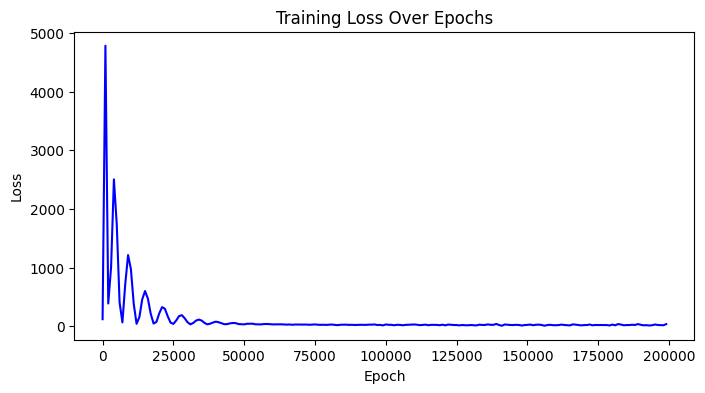

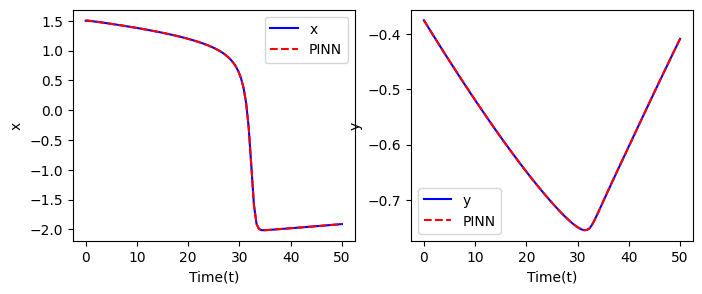

In [ ]:
if __name__=='__main__':

    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_values = []
    epoch_num = 200000
    for epoch in range(epoch_num):

        loss = loss_func(model, tau_tensor, x_real_tensor, y_real_tensor, y0[0], y0[1], mu, random_points=10)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
        loss_values.append(loss.item())

    plt.figure(figsize=(8, 4))
    plt.plot(range(0, epoch_num, 1000), loss_values[:epoch_num//1000], 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()



    # model evaluation
    model.eval()
    with torch.no_grad():
        x_pred, y_pred = model(tau_tensor).numpy().T

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(tau * mu, x_real, 'b-', label='x')
    plt.plot(tau * mu, x_pred, 'r--', label='PINN')
    plt.xlabel('Time(t)')
    plt.ylabel('x')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(tau * mu, y_real, 'b-', label='y')
    plt.plot(tau * mu, y_pred, 'r--', label='PINN')
    plt.xlabel('Time(t)')
    plt.ylabel('y')
    plt.legend()
    plt.show()

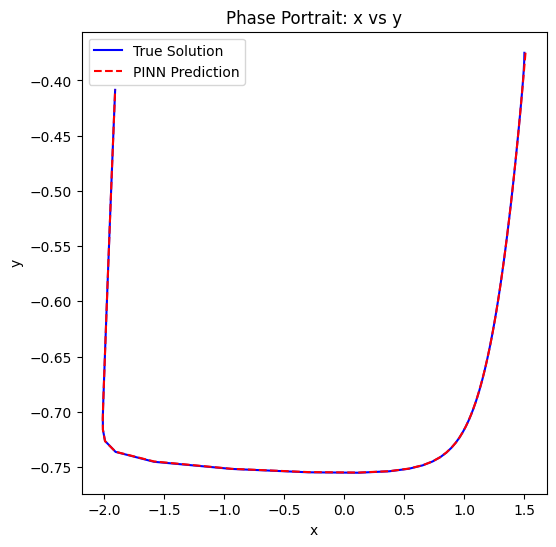

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(x_real, y_real, 'b-', label='True Solution')
plt.plot(x_pred, y_pred, 'r--', label='PINN Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Portrait: x vs y')
plt.legend()
plt.show()